In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy==1.16.4

  Using cached https://files.pythonhosted.org/packages/0f/c9/3526a357b6c35e5529158fbcfac1bb3adc8827e8809a6d254019d326d1cc/numpy-1.16.4-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
ERROR: tensorflow 1.14.0 requires google-pasta>=0.1.6, which is not installed.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4


In [2]:
!conda list

# packages in environment at /anaconda3/envs/unet:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                       mkl  
absl-py                   0.9.0                    py36_0    conda-forge
appnope                   0.1.0                 py36_1000    conda-forge
astor                     0.7.1                      py_0    conda-forge
attrs                     19.3.0                     py_0    conda-forge
backcall                  0.1.0                      py_0    conda-forge
bleach                    3.1.0                      py_0    conda-forge
boto3                     1.11.9                   pypi_0    pypi
botocore                  1.14.9                   pypi_0    pypi
bzip2                     1.0.8                h0b31af3_2    conda-forge
c-ares                    1.15.0            h01d97ff_1001    conda-forge
ca-certificates           2020.1.1                      0    anaconda
cairo                     1.16.0  

In [2]:
import os
import numpy as np 
import cv2
from PIL import Image
from keras_unet.utils import plot_imgs, get_augmented
from sklearn.model_selection import train_test_split
from keras_unet.models import custom_unet
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
IMG_TRAIN_PATH = 'data/train_images/'
MSK_TRAIN_PATH = 'data/train_masks/'
IMG_TEST_PATH = 'data/test_images/'
MSK_TEST_PATH = 'data/test_masks/'
IMG_VAL_PATH = 'data/val_images/'
MSK_VAL_PATH = 'data/val_masks/'

In [4]:
ALL_PATHS = [IMG_TRAIN_PATH, MSK_TRAIN_PATH, IMG_TEST_PATH, 
             MSK_TEST_PATH, IMG_VAL_PATH, MSK_VAL_PATH]

## download images from s3 to local

In [ ]:
fs = s3fs.S3FileSystem()

In [ ]:
len(fs.ls('s3://sagemaker-cgreco/data/test_images'))

In [ ]:
with fs.open('sagemaker-cgreco/data/test_images/1.png') as f:
    display(load_img(f))

In [ ]:
for path in ALL_PATHS:
    if os.path.exists(path):
        pass
    else:
        os.makedirs(path)

In [ ]:
for path in ALL_PATHS:
    for f in fs.ls('s3://sagemaker-cgreco/{0}'.format(path)):
        if f.endswith('.png'):
            with fs.open(f) as img_path:
                img = load_img(img_path)
                img.save('{0}'.format(path) + '/' + f.split('/')[3])

In [ ]:
with fs.open(f) as img_path:
    img = load_img(img_path)

In [5]:
all_training_images = [f for f in os.listdir(IMG_TRAIN_PATH) if f.endswith('.png')]
all_training_masks = [f for f in os.listdir(MSK_TRAIN_PATH) if f.endswith('.png')]

In [12]:
imgs_list = []
masks_list = []
for image, mask in zip(all_training_images, all_training_masks):
    imgs_list.append(np.array(Image.open(IMG_TRAIN_PATH + image).resize((256,256))))
    msk = cv2.imread(MSK_TRAIN_PATH + image, cv2.IMREAD_GRAYSCALE)
    msk = cv2.resize(msk, (256, 256), interpolation=cv2.INTER_NEAREST)
    masks_list.append(msk)
imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

In [13]:
X = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

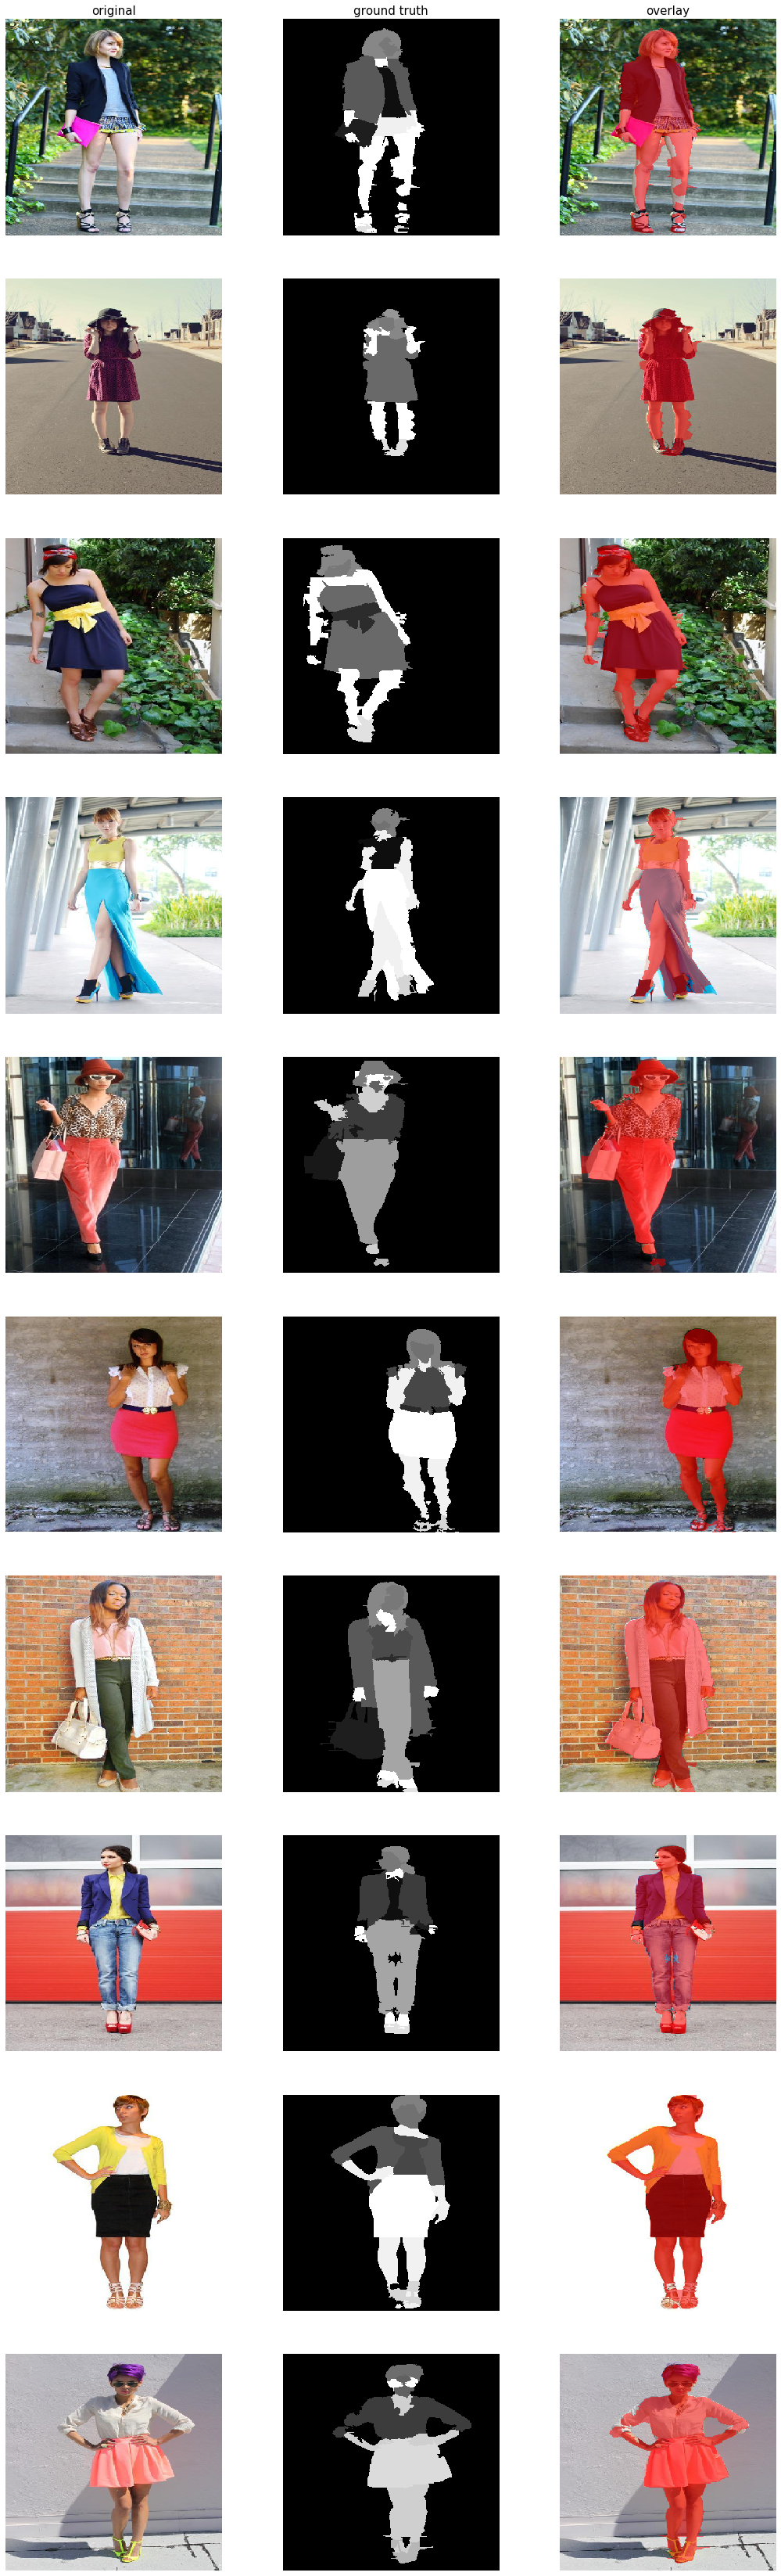

In [14]:
plot_imgs(org_imgs=X, mask_imgs=y, nm_img_to_plot=10, figsize=6)

In [15]:
y = np.where(y == 0, 0, 1)

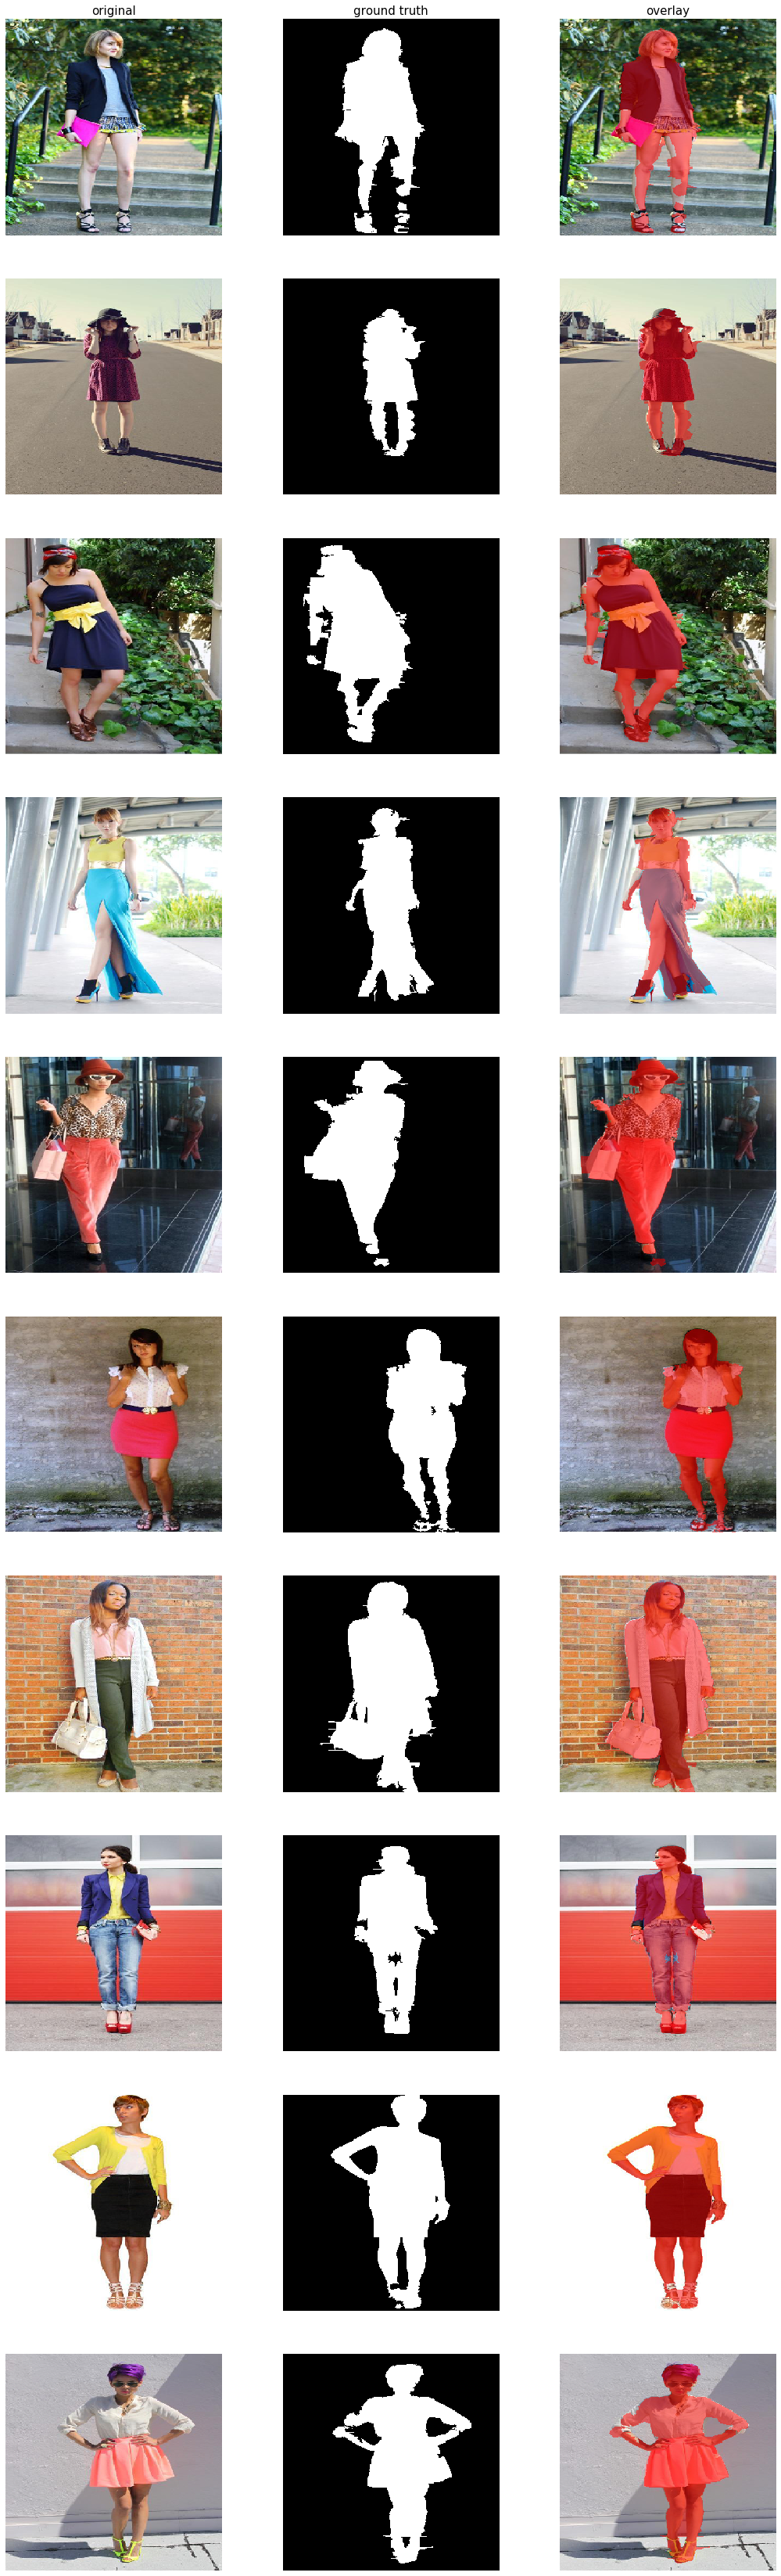

In [16]:
plot_imgs(org_imgs=X, mask_imgs=y, nm_img_to_plot=10, figsize=6)

In [17]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
print("x_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", X_val.shape)
print("y_val: ", y_val.shape)

x_train:  (348, 256, 256, 3)
y_train:  (348, 256, 256, 1)
x_val:  (1395, 256, 256, 3)
y_val:  (1395, 256, 256, 1)


In [19]:
train_gen = get_augmented(
    X_train, y_train, batch_size=32,
    data_gen_args = dict(
        rotation_range=10.,
        #width_shift_range=0.02,
        height_shift_range=0.02,
        #shear_range=5.,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [15]:
unique, counts = np.unique(y, return_counts=True)

In [16]:
for i in range(0,len(counts)):
    a = counts[i]/counts.sum()
    print(str(a))


0.7938619324146785
0.20613806758532144


In [20]:
INPUT_SHAPE = X_train[0].shape
BATCH_SIZE = 32

In [21]:
model = custom_unet(
    input_shape = INPUT_SHAPE,
    filters = 32,
    use_batch_norm = True,
    dropout = 0.3,
    dropout_change_per_layer=0.0,
    num_layers=4)
    #output_activation = 'softmax')







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [50]:
model_filename = 'segm_model_v1.h5'
early_stopper = EarlyStopping(patience = 5, verbose = 1)
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [53]:
def focal_loss(target, output, gamma=2):
    output /= K.sum(output, axis=-1, keepdims=True)
    eps = K.epsilon()
    output = K.clip(output, eps, 1. - eps)
    return -K.sum(K.pow(1. - output, gamma) * target * K.log(output),
                  axis=-1)

In [24]:
import keras.backend as K
import tensorflow as tf
from keras_unet.losses import jaccard_distance

In [26]:
model.compile(
    optimizer='adam', 
    loss=jaccard_distance,
    #loss = 'binary_crossentropy',
    metrics=['accuracy',iou,iou_thresholded])

In [28]:
steps_per_epoch =  len(X_train) // 32

In [30]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopper, callback_checkpoint])

Epoch 1/10
10/10 [==============================] - 1504s 150s/step - loss: 343876.5328 - acc: 0.6104 - iou: 0.1986 - iou_thresholded: 0.2358 - val_loss: 783243.5010 - val_acc: 0.5735 - val_iou: 0.2083 - val_iou_thresholded: 0.2311

Epoch 00001: val_loss improved from inf to 783243.50103, saving model to segm_model_v1.h5
Epoch 2/10
10/10 [==============================] - 1532s 153s/step - loss: 188009.4134 - acc: 0.7504 - iou: 0.2006 - iou_thresholded: 0.2898 - val_loss: 1611262.6617 - val_acc: 0.6292 - val_iou: 0.2366 - val_iou_thresholded: 0.2862

Epoch 00002: val_loss did not improve from 783243.50103
Epoch 3/10


KeyboardInterrupt: 

In [60]:
model_filename = 'segm_model_v1_c2.h5'
model.load_weights(model_filename)
# y_pred = model.predict(x_val)

In [36]:
all_testing_images = [f for f in os.listdir(IMG_TEST_PATH) if f.endswith('.png')]
all_testing_masks = [f for f in os.listdir(MSK_TEST_PATH) if f.endswith('.png')]

In [37]:
imgs_list = []
masks_list = []
for image, mask in zip(all_testing_images, all_testing_masks):
    imgs_list.append(np.array(Image.open(IMG_TEST_PATH + image).resize((256,256))))
    msk = cv2.imread(MSK_TEST_PATH + image, cv2.IMREAD_GRAYSCALE)
    msk = cv2.resize(msk, (256, 256), interpolation=cv2.INTER_NEAREST)
    masks_list.append(msk)
imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

In [38]:
masks_np = np.where(masks_np > 0, 1, 0)

In [39]:
X_test = np.asarray(imgs_np, dtype=np.float32)/255
y_test = np.asarray(masks_np, dtype=np.float32)

In [61]:
y_pred = model.predict(X_val, verbose=1)

1395/1395 [==============================] - 613s 440ms/step


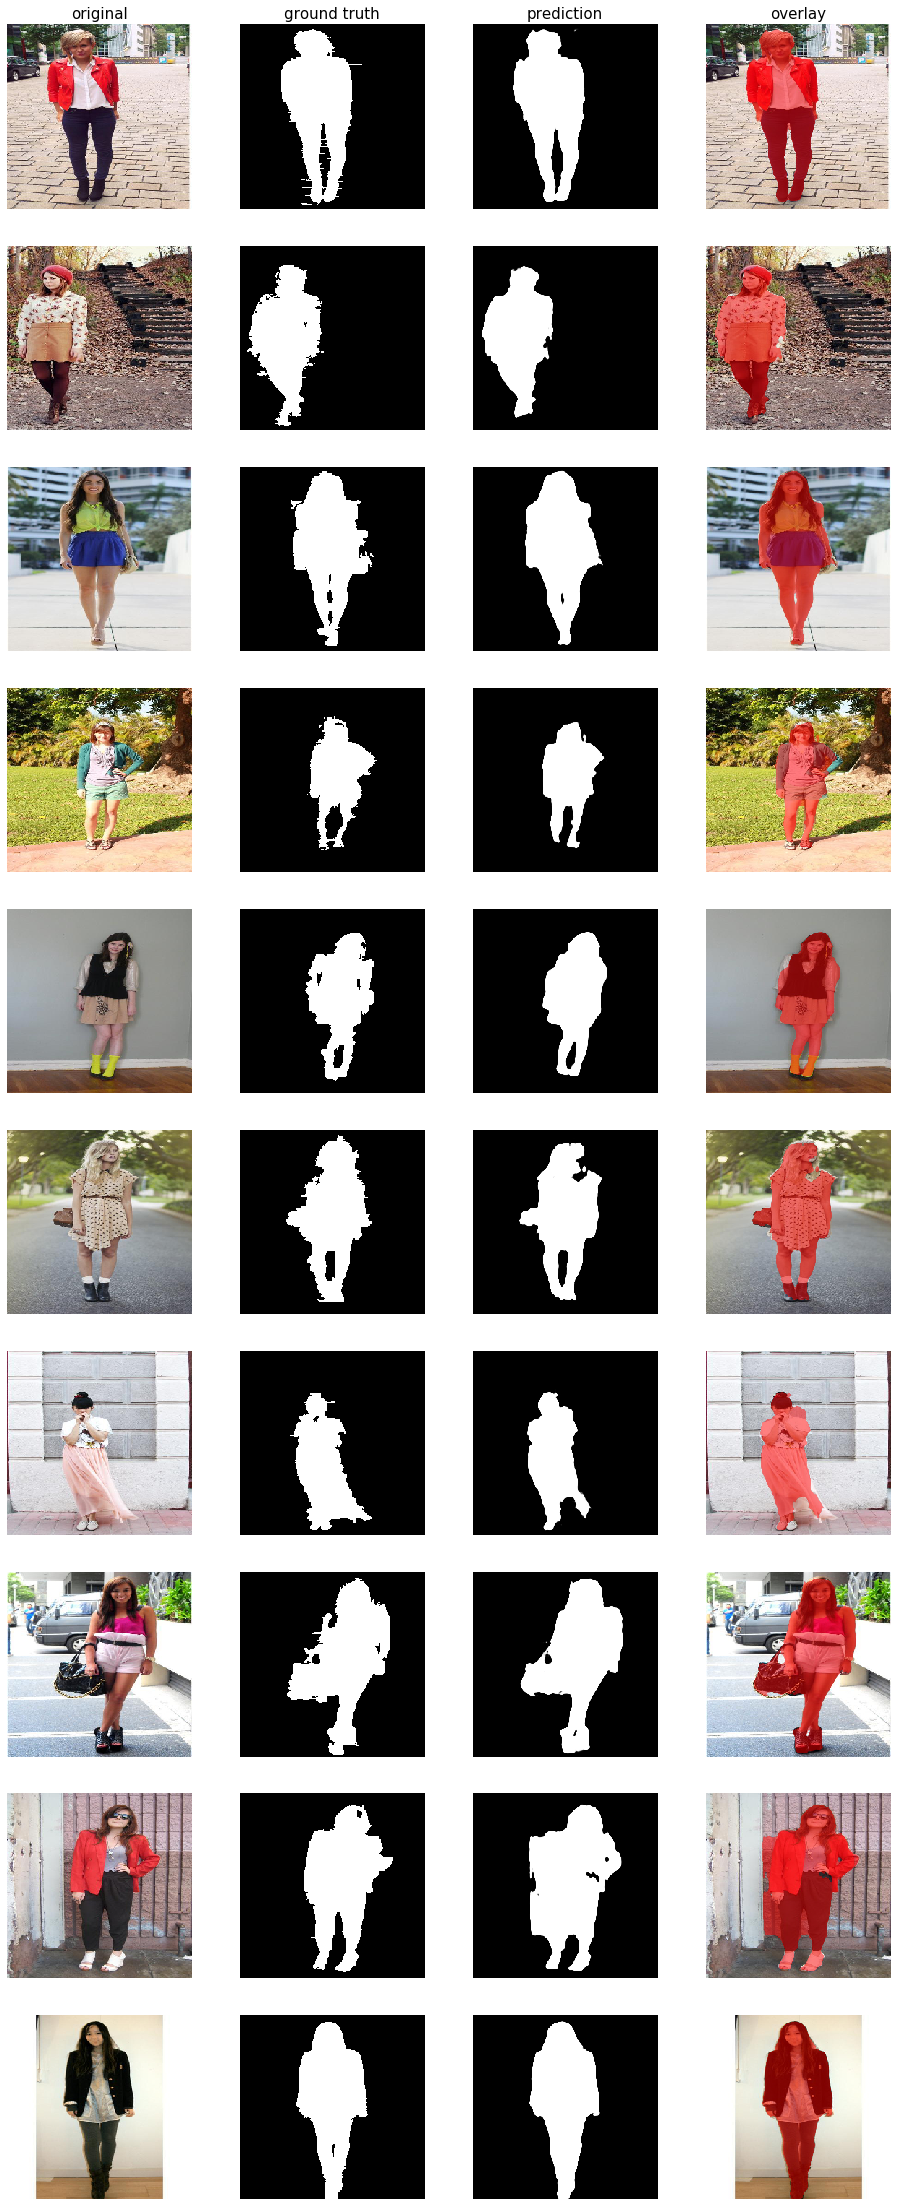

In [62]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)